In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import os
import glob
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.arima.model import ARIMA
from tbats import TBATS
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



Importing plotly failed. Interactive plots will not work.


In [14]:
def adjust_timestamps_in_folder(folder_path, output_folder):
    """
    폴더 내의 모든 CSV 파일을 읽어, 지정된 결측 구간 이후의 데이터를
    결측 구간 시작 시각부터 1시간 단위로 재매핑한 후, 수정된 파일을 출력 폴더에 저장하는 함수.
    """
    # 지정한 결측 구간 (문자열을 datetime으로 변환)
    missing_start = pd.to_datetime("2018-12-04 07:00:00+00:00")
    # missing_end는 참고용으로 남겨두되, 실제 타임스탬프 생성에는 사용하지 않음.
    missing_end = pd.to_datetime("2018-12-13 02:00:00+00:00")
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            if 'Timestamp' not in df.columns:
                print(f"Skipping {filename} (No 'Timestamp' column found)")
                continue

            # Timestamp 컬럼을 datetime으로 변환
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])

            # 결측 구간 이전 데이터와 이후 데이터를 분리합니다.
            df_before_gap = df[df['Timestamp'] < missing_start].copy()
            df_after_gap = df[df['Timestamp'] >= missing_end].copy()

            n_after = len(df_after_gap)
            if n_after == 0:
                print(f"{filename}: 결측 구간 이후 데이터가 없습니다.")
                df_cleaned = df_before_gap.copy()
            else:
                # 1시간 단위 간격을 유지하면서, missing_start부터 n_after개 타임스탬프 생성
                new_timestamps = pd.date_range(start=missing_start, periods=n_after, freq='H')
                df_after_gap['Timestamp'] = new_timestamps
                # 이전 데이터와 수정된 이후 데이터를 합칩니다.
                df_cleaned = pd.concat([df_before_gap, df_after_gap], ignore_index=True)

            output_path = os.path.join(output_folder, filename)
            df_cleaned.to_csv(output_path, index=False)
            print(f"Processed {filename} -> Saved to {output_path}")
            
# 사용 예시 (폴더 경로 변경 필요)
adjust_timestamps_in_folder("./pk_imput_files", "./pk_final_files")


Processed Back Bay_Lyft_Lux Black XL.csv -> Saved to ./pk_final_files\Back Bay_Lyft_Lux Black XL.csv
Processed Back Bay_Lyft_Lux Black.csv -> Saved to ./pk_final_files\Back Bay_Lyft_Lux Black.csv
Processed Back Bay_Lyft_Lux.csv -> Saved to ./pk_final_files\Back Bay_Lyft_Lux.csv
Processed Back Bay_Lyft_Lyft XL.csv -> Saved to ./pk_final_files\Back Bay_Lyft_Lyft XL.csv
Processed Back Bay_Lyft_Lyft.csv -> Saved to ./pk_final_files\Back Bay_Lyft_Lyft.csv
Processed Back Bay_Lyft_Shared.csv -> Saved to ./pk_final_files\Back Bay_Lyft_Shared.csv
Processed Back Bay_Uber_Black SUV.csv -> Saved to ./pk_final_files\Back Bay_Uber_Black SUV.csv
Processed Back Bay_Uber_Black.csv -> Saved to ./pk_final_files\Back Bay_Uber_Black.csv
Processed Back Bay_Uber_UberPool.csv -> Saved to ./pk_final_files\Back Bay_Uber_UberPool.csv
Processed Back Bay_Uber_UberX.csv -> Saved to ./pk_final_files\Back Bay_Uber_UberX.csv
Processed Back Bay_Uber_UberXL.csv -> Saved to ./pk_final_files\Back Bay_Uber_UberXL.csv
Proce

In [18]:
import os
import pandas as pd

def fill_missing_price_columns_modify(input_folder):
    """
    지정한 폴더 내의 모든 CSV 파일에서,
    'price'로 시작하는 컬럼의 결측값을 수치형이면 중앙값(median),
    수치형이 아니면 최빈값(mode)으로 채워서 원본 파일에 덮어씁니다.
    
    :param input_folder: 원본 CSV 파일들이 있는 폴더 경로 (예: "./pk_final_files")
    """
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            df = pd.read_csv(file_path)
            
            # 'price'로 시작하는 컬럼 (대소문자 무시) 선택
            price_cols = [col for col in df.columns if col.lower().startswith("price")]
            if not price_cols:
                print(f"{filename}: 'price'로 시작하는 컬럼이 없습니다. 건너뜁니다.")
                continue
            
            print(f"처리 전 {filename}의 'price' 관련 컬럼 결측값 요약:")
            print(df[price_cols].isnull().sum())
            
            for col in price_cols:
                if df[col].isnull().sum() > 0:
                    if pd.api.types.is_numeric_dtype(df[col]):
                        median_val = df[col].median()
                        if pd.isnull(median_val):
                            print(f"{filename}: '{col}' 컬럼은 모두 NaN입니다. 대체 불가.")
                        else:
                            df[col] = df[col].fillna(median_val)
                            print(f"{filename}: '{col}' 결측값을 중앙값({median_val})으로 대체했습니다.")
                    else:
                        mode_series = df[col].mode()
                        if not mode_series.empty:
                            mode_val = mode_series.iloc[0]
                            df[col] = df[col].fillna(mode_val)
                            print(f"{filename}: '{col}' 결측값을 최빈값({mode_val})으로 대체했습니다.")
                        else:
                            print(f"{filename}: '{col}' 컬럼은 최빈값 계산 불가, 대체하지 못했습니다.")
            
            print(f"처리 후 {filename}의 'price' 관련 컬럼 결측값 요약:")
            print(df[price_cols].isnull().sum())
            
            # 원본 파일 덮어쓰기
            df.to_csv(file_path, index=False)
            print(f"Processed {filename} -> 원본 파일을 수정했습니다.\n")

# 사용 예시
fill_missing_price_columns_modify("./pk_final_files")


처리 전 Back Bay_Lyft_Lux Black XL.csv의 'price' 관련 컬럼 결측값 요약:
price_max     1
price_mean    1
price_min     1
dtype: int64
Back Bay_Lyft_Lux Black XL.csv: 'price_max' 결측값을 중앙값(45.5)으로 대체했습니다.
Back Bay_Lyft_Lux Black XL.csv: 'price_mean' 결측값을 중앙값(31.02380952380953)으로 대체했습니다.
Back Bay_Lyft_Lux Black XL.csv: 'price_min' 결측값을 중앙값(26.0)으로 대체했습니다.
처리 후 Back Bay_Lyft_Lux Black XL.csv의 'price' 관련 컬럼 결측값 요약:
price_max     0
price_mean    0
price_min     0
dtype: int64
Processed Back Bay_Lyft_Lux Black XL.csv -> 원본 파일을 수정했습니다.

처리 전 Back Bay_Lyft_Lux Black.csv의 'price' 관련 컬럼 결측값 요약:
price_max     1
price_mean    1
price_min     1
dtype: int64
Back Bay_Lyft_Lux Black.csv: 'price_max' 결측값을 중앙값(32.5)으로 대체했습니다.
Back Bay_Lyft_Lux Black.csv: 'price_mean' 결측값을 중앙값(21.5625)으로 대체했습니다.
Back Bay_Lyft_Lux Black.csv: 'price_min' 결측값을 중앙값(16.5)으로 대체했습니다.
처리 후 Back Bay_Lyft_Lux Black.csv의 'price' 관련 컬럼 결측값 요약:
price_max     0
price_mean    0
price_min     0
dtype: int64
Processed Back Bay_Lyft_Lux Black.csv -> 원본

In [19]:
df = pd.read_csv('./pk_final_files/Back Bay_Lyft_Lux Black XL.csv')
df["price_mean"].count()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
df.set_index('Timestamp', inplace=True)


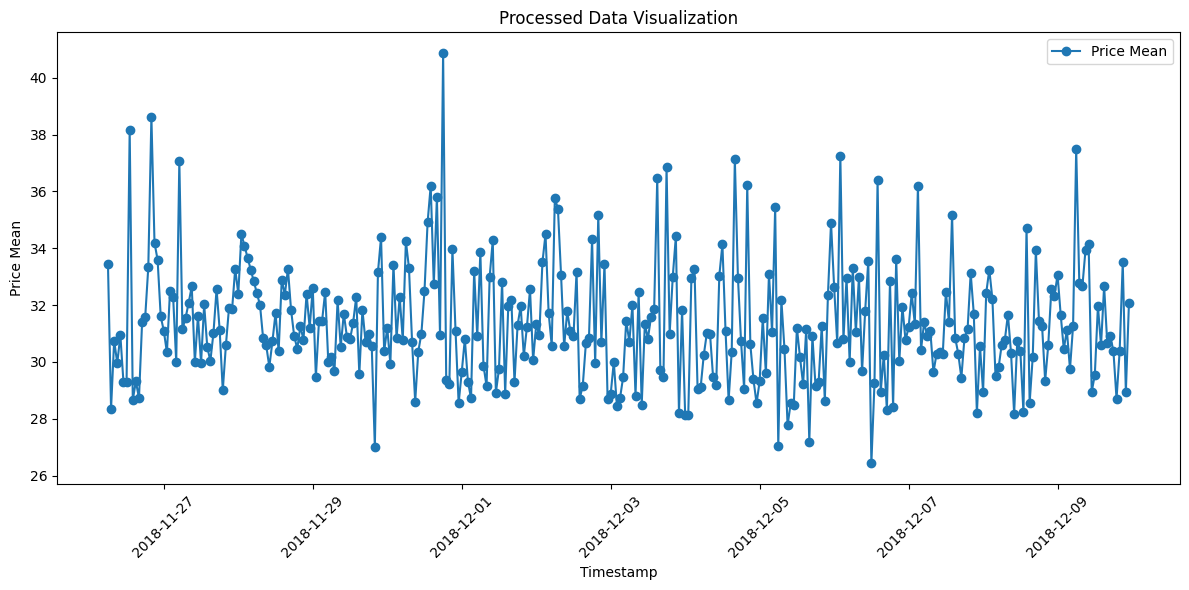

In [20]:
# 처리된 파일 경로 (예시)
processed_file = './pk_final_files/Back Bay_Lyft_Lux Black XL.csv'

# CSV 파일 읽기
df = pd.read_csv(processed_file)

# Timestamp 컬럼을 datetime 형식으로 변환 및 정렬
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

# 데이터 시각화 (예시: 'price_mean' 컬럼)
plt.figure(figsize=(12,6))
plt.plot(df['Timestamp'], df['price_mean'], marker='o', linestyle='-', label='Price Mean')
plt.xlabel('Timestamp')
plt.ylabel('Price Mean')
plt.title('Processed Data Visualization')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

def run_stationarity_tests(series):
    print("=== ADF 검정 결과 ===")
    adf_result = adfuller(series, autolag='AIC')
    adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, adf_icbest = adf_result
    print(f"검정 통계량: {adf_stat:.4f}")
    print(f"p-value: {adf_p:.4f}")
    print(f"사용된 lag 수: {adf_lags}")
    print(f"관측치 수: {adf_nobs}")
    print("임계값:")
    for key, value in adf_crit.items():
        print(f"  {key} 유의수준: {value:.4f}")
        
    # ADF 검정의 귀무가설은 "단위근이 존재하여 시계열이 비정상이다"입니다.
    # 검정 통계량이 임계값보다 작으면 귀무가설을 기각하여 정상성을 인정함.
    if adf_stat < adf_crit["5%"]:
        adf_conclusion = "정상"
        print("=> ADF 검정 결과: 귀무가설(비정상)을 기각합니다. 시계열은 정상입니다.\n")
    else:
        adf_conclusion = "비정상"
        print("=> ADF 검정 결과: 귀무가설(비정상)을 기각하지 못했습니다. 시계열은 비정상입니다.\n")
    
    print("=== KPSS 검정 결과 ===")
    kpss_result = kpss(series, regression='c', nlags="auto")
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss_result
    print(f"검정 통계량: {kpss_stat:.4f}")
    print(f"p-value: {kpss_p:.4f}")
    print(f"사용된 lag 수: {kpss_lags}")
    print("임계값:")
    for key, value in kpss_crit.items():
        print(f"  {key} 유의수준: {value:.4f}")
        
    # KPSS 검정의 귀무가설은 "시계열이 정상이다"입니다.
    # 검정 통계량이 각 유의수준의 임계값보다 크면 귀무가설을 기각하여 비정상으로 판단합니다.
    kpss_conclusion = "정상"
    for level, crit in kpss_crit.items():
        if kpss_stat > crit:
            kpss_conclusion = "비정상"
            print(f"{level} 유의수준: KPSS 검정 통계량이 임계값보다 큽니다. (비정상)")
        else:
            print(f"{level} 유의수준: KPSS 검정 통계량이 임계값 이하입니다. (정상)")
    
    print("\n=== 종합 결과 ===")
    print(f"ADF 검정 결론: {adf_conclusion}")
    print(f"KPSS 검정 결론: {kpss_conclusion}")
    
    if adf_conclusion == "정상" and kpss_conclusion == "정상":
        print("=> 최종 결론: 시계열은 정상입니다.")
    elif adf_conclusion == "비정상" and kpss_conclusion == "비정상":
        print("=> 최종 결론: 시계열은 비정상입니다.")
    else:
        print("=> 최종 결론: 검정 결과가 상반됩니다. 추가 분석이 필요합니다.")

# 예시 사용:
series = df['price_mean']
run_stationarity_tests(series)


=== ADF 검정 결과 ===
검정 통계량: -17.6246
p-value: 0.0000
사용된 lag 수: 0
관측치 수: 329
임계값:
  1% 유의수준: -3.4504
  5% 유의수준: -2.8704
  10% 유의수준: -2.5715
=> ADF 검정 결과: 귀무가설(비정상)을 기각합니다. 시계열은 정상입니다.

=== KPSS 검정 결과 ===
검정 통계량: 0.2821
p-value: 0.1000
사용된 lag 수: 5
임계값:
  10% 유의수준: 0.3470
  5% 유의수준: 0.4630
  2.5% 유의수준: 0.5740
  1% 유의수준: 0.7390
10% 유의수준: KPSS 검정 통계량이 임계값 이하입니다. (정상)
5% 유의수준: KPSS 검정 통계량이 임계값 이하입니다. (정상)
2.5% 유의수준: KPSS 검정 통계량이 임계값 이하입니다. (정상)
1% 유의수준: KPSS 검정 통계량이 임계값 이하입니다. (정상)

=== 종합 결과 ===
ADF 검정 결론: 정상
KPSS 검정 결론: 정상
=> 최종 결론: 시계열은 정상입니다.


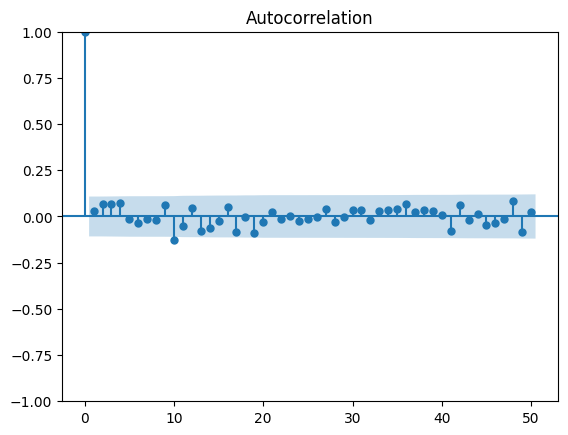

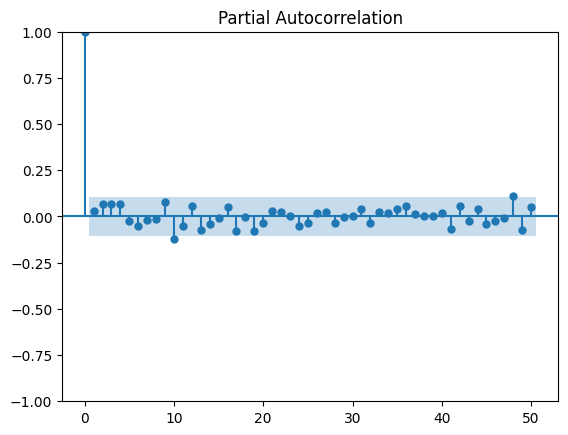

In [22]:
plot_acf(df['price_mean'], lags=50)
plt.show()

plot_pacf(df['price_mean'], lags=50)
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-508.181, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=308.683, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-512.713, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-511.281, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-511.226, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-529.448, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-188.038, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-530.750, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-532.934, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-533.235, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-548.177, Time=0.26 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-548.471, Time=0.55 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-5

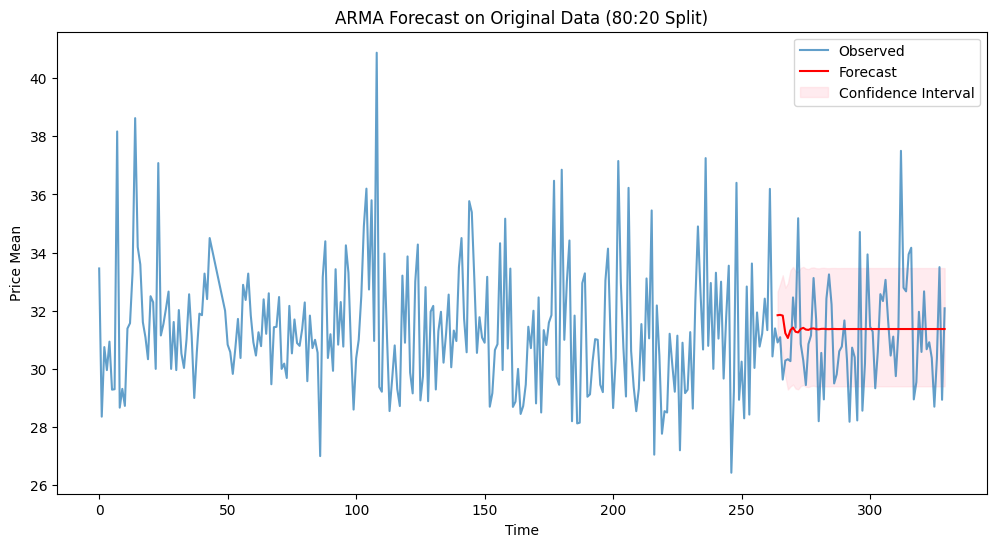

In [23]:
import os
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency D will be used.")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

# ----------------------------
# 1. 데이터 전처리 (로그 변환 + 스무딩 + Min–Max Scaling)
# ----------------------------
def log_smooth_scale_series(series, window=12):
    """
    로그 변환, 이동평균 스무딩, 그리고 Min–Max Scaling을 적용.
    반환값:
      - scaled_series: 스케일된 시계열 (0~1 범위)
      - scale_min: 스무딩된 로그 시계열의 최소값 (역변환에 사용)
      - scale_max: 스무딩된 로그 시계열의 최대값 (역변환에 사용)
    """
    # 로그 변환 (음수 방지)
    log_series = np.log1p(series)
    # 이동평균 스무딩
    smoothed_series = log_series.rolling(window=window, min_periods=1).mean()
    # Min–Max Scaling
    scale_min = smoothed_series.min()
    scale_max = smoothed_series.max()
    scaled_series = (smoothed_series - scale_min) / (scale_max - scale_min)
    return scaled_series, scale_min, scale_max

# 데이터 로드: df에서 'price_mean' 칼럼 사용, 결측치는 보간
series = df['price_mean']
series = series.interpolate()

# 전처리: 로그 변환, 스무딩, 그리고 스케일링 (예: window=6 → 6시간 이동평균)
window_size = 6
scaled_series, scale_min, scale_max = log_smooth_scale_series(series, window=window_size)

# ----------------------------
# 2. 데이터 분할 (80:20)
# ----------------------------
split_index = int(len(scaled_series) * 0.8)
train_scaled = scaled_series.iloc[:split_index]
test_scaled  = scaled_series.iloc[split_index:]
# 원본 시계열 분할 (평가용)
train_original = series.iloc[:split_index]
test_original  = series.iloc[split_index:]
horizon = len(test_scaled)

# ----------------------------
# 3. 평가 지표 계산 함수
# ----------------------------
def evaluate_forecast(actual, forecast, eps=1e-8):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    diff_actual = np.abs(np.diff(actual))
    scale = np.mean(diff_actual) if np.mean(diff_actual) != 0 else eps
    mase = mae / scale
    
    denom = (np.abs(actual) + np.abs(forecast)) / 2
    smape = 100 * np.mean(np.abs(forecast - actual) / np.where(denom == 0, eps, denom))
    
    msape = 100 * np.median(np.abs(forecast - actual) / np.where(actual == 0, eps, actual))
    
    return {"MAE": mae, "RMSE": rmse, "MASE": mase, "sMAPE": smape, "msAPE": msape}

# ----------------------------
# 4. 모델 학습 및 예측 (학습 데이터로 fit, 테스트 구간 예측)
# ----------------------------
# ARMA 모델 찾기: 데이터가 이미 정상이므로, d=0, seasonal=False 옵션을 사용
model = pm.auto_arima(train_scaled, d=0, seasonal=False, stepwise=True, trace=True)
print(model.summary())

# 테스트 데이터 길이(horizon)만큼 예측
forecast_scaled, conf_int_scaled = model.predict(n_periods=horizon, return_conf_int=True)
# 예측 결과의 index는 테스트 데이터와 동일하게 설정
forecast_series_scaled = pd.Series(forecast_scaled, index=test_scaled.index)

# ----------------------------
# 5. 역변환: 스케일 복원 후 역 로그 변환
# ----------------------------
# 역 스케일링: 원래의 스무딩된 로그값 복원
forecast_series_log = forecast_series_scaled * (scale_max - scale_min) + scale_min
conf_int_log = np.column_stack((
    conf_int_scaled[:, 0] * (scale_max - scale_min) + scale_min,
    conf_int_scaled[:, 1] * (scale_max - scale_min) + scale_min
))
# 역 로그 변환: np.expm1로 복원
forecast_series_final = np.expm1(forecast_series_log)
conf_int_final = np.column_stack((
    np.expm1(conf_int_log[:, 0]),
    np.expm1(conf_int_log[:, 1])
))

# ----------------------------
# 6. 평가 수행
# ----------------------------
metrics = evaluate_forecast(test_original, forecast_series_final)
print("Evaluation Metrics:", metrics)

# ----------------------------
# 7. 결과 시각화 (원본 데이터 기준)
# ----------------------------
plt.figure(figsize=(12, 6))
# 원본 데이터 플롯 (price_mean)
plt.plot(series.index, series, label='Observed', alpha=0.7)
# 예측 결과 플롯 (역변환된 값)
plt.plot(forecast_series_final.index, forecast_series_final, label='Forecast', color='red', linestyle='-')
# 신뢰 구간 플롯
plt.fill_between(forecast_series_final.index,
                 conf_int_final[:, 0],
                 conf_int_final[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel("Time")
plt.ylabel("Price Mean")
plt.title("ARMA Forecast on Original Data (80:20 Split)")
plt.legend()
plt.show()


In [19]:
import os
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # 진행 바용 라이브러리

# 모델 관련 라이브러리
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from tbats import TBATS
from prophet import Prophet
from pmdarima import auto_arima  # auto_arima 추가

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency h will be used.")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

# ----------------------------
# 1. 데이터 전처리 (로그 변환 + 스무딩 + Min–Max Scaling)
# ----------------------------
def transform_train_test(series, window=6):
    """
    series: 원본 시계열 (pandas Series)
    window: 이동평균 윈도우 (시간 단위)
    
    반환:
      - train_scaled, test_scaled: 스케일된 값 (로그 변환+스무딩+Min–Max Scaling)
      - train_original, test_original: 원본 값 (평가 시 사용)
      - scale_min, scale_max: 스무딩된 로그 시계열의 최소/최대 (inversion에 필요)
    """
    # Train/Test 분할 (80:20)
    split_index = int(len(series) * 0.8)
    train_original = series.iloc[:split_index]
    test_original = series.iloc[split_index:]
    
    # 로그 변환 + 스무딩 (학습 데이터)
    train_log = np.log1p(train_original)
    train_smoothed = train_log.rolling(window=window, min_periods=1).mean()
    scale_min = train_smoothed.min()
    scale_max = train_smoothed.max()
    train_scaled = (train_smoothed - scale_min) / (scale_max - scale_min)
    
    # 테스트 데이터에도 동일한 변환 적용 (단, scaling은 학습 데이터의 scale_min, scale_max 사용)
    test_log = np.log1p(test_original)
    test_smoothed = test_log.rolling(window=window, min_periods=1).mean()
    test_scaled = (test_smoothed - scale_min) / (scale_max - scale_min)
    
    return train_scaled, test_scaled, train_original, test_original, scale_min, scale_max

# ----------------------------
# 2. 예측 결과 시각화 함수 (옵션)
# ----------------------------
def plot_forecast(train, test, forecast, model_name, file_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(forecast.index, forecast, label=f'{model_name} Forecast', color='red')
    plt.xlabel("Time")
    plt.ylabel("Price Mean")
    plt.title(f"{file_name} - {model_name} Forecast vs Test Data")
    plt.legend()
    plt.show()

# ----------------------------
# 3. 평가 지표 계산 함수 (sMAPE, MASE, MAE, RMSE)
# ----------------------------
def calculate_metrics(actual, forecast, train):
    # 실제값과 예측값은 모두 원본 스케일이어야 함
    actual = actual.reindex(forecast.index)
    error = forecast - actual
    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error**2))
    
    # sMAPE 계산 (분모가 0인 경우 NaN 처리)
    denom = np.abs(forecast) + np.abs(actual)
    denom = denom.replace(0, np.nan)
    smape = np.nanmean(2 * np.abs(error) / denom) * 100
    
    # MASE: 훈련 데이터에 대한 naive 예측(시차 1) MAE로 스케일 조정
    if len(train) > 1:
        naive_errors = np.abs(train.diff().dropna())
        scale = np.mean(naive_errors)
    else:
        scale = np.nan
    mase = mae / scale if scale != 0 else np.nan
    
    return {
        "sMAPE": smape,
        "MASE": mase,
        "MAE": mae,
        "RMSE": rmse
    }

# ----------------------------
# 4. 모델 예측 및 평가를 수행하는 함수 (스케일링 포함)
# ----------------------------
def process_file(file_path, plot=False, window=6):
    # CSV 파일 읽기 (컬럼: 'Timestamp', 'price_mean')
    df = pd.read_csv(file_path, parse_dates=['Timestamp'])
    df.set_index('Timestamp', inplace=True)
    series = df['price_mean'].interpolate()
    
    # 로그 변환, 스무딩, 그리고 Min–Max Scaling (train/test)
    train_scaled, test_scaled, train_original, test_original, scale_min, scale_max = transform_train_test(series, window=window)
    horizon = len(test_original)  # 예측 기간

    forecasts = {}
    model_times = {}
    
    # Helper: Inverse transformation (예측값이 스케일된 경우 원래 스케일로 복원)
    def inverse_transform(scaled_pred):
        log_pred = scaled_pred * (scale_max - scale_min) + scale_min
        return np.expm1(log_pred)
    
    # 4-1. SES (단순 지수평활)
    start = time.time()
    ses_model = SimpleExpSmoothing(train_scaled, initialization_method="estimated").fit()
    ses_forecast_scaled = ses_model.forecast(horizon)
    model_times["SES"] = time.time() - start
    ses_forecast = pd.Series(inverse_transform(ses_forecast_scaled), index=test_original.index)
    forecasts["SES"] = ses_forecast
    if plot:
        plot_forecast(train_original, test_original, ses_forecast, "SES", os.path.basename(file_path))
    
    # 4-2. Theta 모델 (시간 빈도 명시)
    start = time.time()
    train_scaled_freq = train_scaled.asfreq('h')
    theta_model = ThetaModel(train_scaled_freq).fit()
    theta_forecast_scaled = theta_model.forecast(horizon)
    model_times["Theta"] = time.time() - start
    theta_forecast = pd.Series(inverse_transform(theta_forecast_scaled), index=test_original.index)
    forecasts["Theta"] = theta_forecast
    if plot:
        plot_forecast(train_original, test_original, theta_forecast, "Theta", os.path.basename(file_path))
    
    # 4-3. TBATS 모델
    start = time.time()
    tbats_estimator = TBATS(seasonal_periods=[6])
    tbats_model = tbats_estimator.fit(train_scaled)
    tbats_forecast_scaled = tbats_model.forecast(steps=horizon)
    forecast_index = pd.date_range(start=train_scaled.index[-1] + pd.Timedelta(hours=1), periods=horizon, freq='h')
    tbats_forecast_scaled_series = pd.Series(tbats_forecast_scaled, index=forecast_index)
    model_times["TBATS"] = time.time() - start
    tbats_forecast = pd.Series(inverse_transform(tbats_forecast_scaled_series), index=test_original.index)
    forecasts["TBATS"] = tbats_forecast
    if plot:
        plot_forecast(train_original, test_original, tbats_forecast, "TBATS", os.path.basename(file_path))
    
    # 4-4. ETS (추세만 고려하는 지수평활 모형)
    start = time.time()
    ets_model = ExponentialSmoothing(train_scaled, trend="add", seasonal=None, initialization_method="estimated").fit()
    ets_forecast_scaled = ets_model.forecast(horizon)
    model_times["ETS"] = time.time() - start
    ets_forecast = pd.Series(inverse_transform(ets_forecast_scaled), index=test_original.index)
    forecasts["ETS"] = ets_forecast
    if plot:
        plot_forecast(train_original, test_original, ets_forecast, "ETS", os.path.basename(file_path))
    
    # 4-5. Auto ARIMA 모델 (최적 모형 자동 선택)
    start = time.time()
    auto_arima_model = auto_arima(train_scaled, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')
    arima_forecast_scaled = auto_arima_model.predict(n_periods=horizon)
    model_times["ARIMA"] = time.time() - start
    arima_forecast = pd.Series(inverse_transform(arima_forecast_scaled), index=test_original.index)
    forecasts["ARIMA"] = arima_forecast
    if plot:
        plot_forecast(train_original, test_original, arima_forecast, "ARIMA", os.path.basename(file_path))
    
    # 4-6. Prophet 모델 (원본 스케일 사용 및 인덱스 정렬 문제 수정)
    start = time.time()
    prophet_train = train_original.reset_index()
    prophet_train.columns = ['ds', 'y']
    prophet_train['ds'] = pd.to_datetime(prophet_train['ds']).dt.tz_localize(None)
    prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
    prophet_model.fit(prophet_train)
    future_df = prophet_model.make_future_dataframe(periods=horizon, freq='h')
    prophet_forecast_df = prophet_model.predict(future_df)
    prophet_forecast_original = prophet_forecast_df.set_index('ds')['yhat'].iloc[-horizon:]
    model_times["Prophet"] = time.time() - start
    forecasts["Prophet"] = prophet_forecast_original
    if plot:
        plot_forecast(train_original, test_original, prophet_forecast_original, "Prophet", os.path.basename(file_path))
    
    # 평가 지표 계산 (원본 스케일: 실제 시계열 vs 예측 결과)
    metrics = {}
    for model_name, forecast in forecasts.items():
        metrics[model_name] = calculate_metrics(test_original, forecast, train_original)
        metrics[model_name]["Execution Time"] = model_times.get(model_name, np.nan)
    
    return metrics

# ----------------------------
# 5. 디렉토리 내 모든 CSV 파일에 대해 반복 처리 (진행 바 표시)
# ----------------------------
directory = "./pk_final_files"  # CSV 파일들이 있는 디렉토리 경로
csv_files = glob.glob(os.path.join(directory, "*.csv"))

all_metrics = []  # 각 파일별 평가 지표 저장 리스트

for file_path in tqdm(csv_files, desc="Processing CSV files", unit="file"):
    try:
        file_metrics = process_file(file_path, plot=False, window=6)  # window=6 (6시간 이동평균)
        entry = {"file": os.path.basename(file_path)}
        for model, met in file_metrics.items():
            for metric_name, value in met.items():
                # 예: "SES_MAE", "Prophet_RMSE", "SES_Execution Time"
                entry[f"{model}_{metric_name}"] = value
        all_metrics.append(entry)
    except Exception as e:
        tqdm.write(f"Error processing {file_path}: {e}")

# 파일별 평가 결과 DataFrame 생성
metrics_df = pd.DataFrame(all_metrics)
print(metrics_df)

# ----------------------------
# 6. 전체 데이터셋에 대한 평가 (행: 모델명, 열: 평가지표)
# ----------------------------
metrics_list = ["sMAPE", "MASE", "MAE", "RMSE", "Execution Time"]
models = ["SES", "Theta", "TBATS", "ETS", "ARIMA", "Prophet"]
aggregate_metrics = {}
for model in models:
    aggregate_metrics[model] = {}
    for metric in metrics_list:
        col_name = f"{model}_{metric}"
        if col_name in metrics_df.columns:
            aggregate_metrics[model][metric] = metrics_df[col_name].mean()
        else:
            aggregate_metrics[model][metric] = np.nan

aggregate_df = pd.DataFrame.from_dict(aggregate_metrics, orient="index")

# 전체 데이터셋 평가지표를 CSV 파일로 저장
aggregate_df.to_csv("./aggregate_metrics.csv", index=True)

print("\nAggregate metrics across all CSV files:")
print(aggregate_df)


Processing CSV files: 100%|██████████| 144/144 [1:02:11<00:00, 25.91s/file]

                               file  SES_sMAPE  SES_MASE   SES_MAE  SES_RMSE  \
0    Back Bay_Lyft_Lux Black XL.csv   5.332475  0.703085  1.681041  2.241874   
1       Back Bay_Lyft_Lux Black.csv   5.416961  0.593451  1.180841  1.461516   
2             Back Bay_Lyft_Lux.csv   5.727278  0.641004  0.973417  1.308268   
3         Back Bay_Lyft_Lyft XL.csv   7.010121  0.813931  1.045456  1.274735   
4            Back Bay_Lyft_Lyft.csv   6.906890  0.767736  0.643981  0.904576   
..                              ...        ...       ...       ...       ...   
139         West End_Uber_Black.csv   4.881622  0.755967  0.993509  1.228364   
140      West End_Uber_UberPool.csv   3.923307  0.608647  0.341047  0.409972   
141         West End_Uber_UberX.csv   5.860344  0.928658  0.567617  0.753075   
142        West End_Uber_UberXL.csv   5.131197  0.763163  0.803977  1.071708   
143           West End_Uber_WAV.csv   3.375457  0.572441  0.322145  0.400210   

     SES_Execution Time  Theta_sMAPE  T

In [9]:
input_folder = "./pk_final_files"  # CSV 파일들이 있는 폴더 경로

for file in os.listdir(input_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(input_folder, file)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"{file} 파일 읽기 에러: {e}")
            continue

        if 'Timestamp' in df.columns:
            try:
                # Timestamp 컬럼을 datetime 형식으로 변환
                df['Timestamp'] = pd.to_datetime(df['Timestamp'])
                # YYYY-MM-DD 문자열 포맷으로 변경한 후 다시 datetime으로 변환
                df['Timestamp'] = pd.to_datetime(df['Timestamp'].dt.strftime('%Y-%m-%d'))
            except Exception as e:
                print(f"{file} 처리 중 에러 발생: {e}")
                continue

            # 원본 파일에 덮어쓰기
            df.to_csv(file_path, index=False)
            print(f"{file} 처리 완료 및 저장")
        else:
            print(f"{file} 파일에 'Timestamp' 컬럼이 없습니다.")


Back Bay_Lyft_Lux Black XL.csv 처리 완료 및 저장
Back Bay_Lyft_Lux Black.csv 처리 완료 및 저장
Back Bay_Lyft_Lux.csv 처리 완료 및 저장
Back Bay_Lyft_Lyft XL.csv 처리 완료 및 저장
Back Bay_Lyft_Lyft.csv 처리 완료 및 저장
Back Bay_Lyft_Shared.csv 처리 완료 및 저장
Back Bay_Uber_Black SUV.csv 처리 완료 및 저장
Back Bay_Uber_Black.csv 처리 완료 및 저장
Back Bay_Uber_UberPool.csv 처리 완료 및 저장
Back Bay_Uber_UberX.csv 처리 완료 및 저장
Back Bay_Uber_UberXL.csv 처리 완료 및 저장
Back Bay_Uber_WAV.csv 처리 완료 및 저장
Beacon Hill_Lyft_Lux Black XL.csv 처리 완료 및 저장
Beacon Hill_Lyft_Lux Black.csv 처리 완료 및 저장
Beacon Hill_Lyft_Lux.csv 처리 완료 및 저장
Beacon Hill_Lyft_Lyft XL.csv 처리 완료 및 저장
Beacon Hill_Lyft_Lyft.csv 처리 완료 및 저장
Beacon Hill_Lyft_Shared.csv 처리 완료 및 저장
Beacon Hill_Uber_Black SUV.csv 처리 완료 및 저장
Beacon Hill_Uber_Black.csv 처리 완료 및 저장
Beacon Hill_Uber_UberPool.csv 처리 완료 및 저장
Beacon Hill_Uber_UberX.csv 처리 완료 및 저장
Beacon Hill_Uber_UberXL.csv 처리 완료 및 저장
Beacon Hill_Uber_WAV.csv 처리 완료 및 저장
Boston University_Lyft_Lux Black XL.csv 처리 완료 및 저장
Boston University_Lyft_Lux Black.csv 처리

In [25]:
df = pd.read_csv("./pk_final_files/Back Bay_Lyft_Lux.csv")
df

,Timestamp,Location,Provider,Service_Type,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_max,price_mean,price_min,rain,surge_max,surge_mean,surge_min,temp,wind
0,2018-11-26 06:00:00+00:00,Back Bay,Lyft,Lux,9.0,0.990667,3.03,1.726667,1.04,0.913333,22.5,16.555556,11.0,0.0,1.50,1.055556,1.0,40.627333,1.350667
1,2018-11-26 07:00:00+00:00,Back Bay,Lyft,Lux,10.0,0.970000,2.67,1.690000,1.09,0.920000,27.5,17.300000,13.5,0.0,2.00,1.100000,1.0,41.137500,1.735000
2,2018-11-26 08:00:00+00:00,Back Bay,Lyft,Lux,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.5,13.500000,13.5,0.0,1.00,1.000000,1.0,40.920000,1.330000
3,2018-11-26 09:00:00+00:00,Back Bay,Lyft,Lux,11.0,1.000000,3.08,1.920909,1.39,0.927500,32.5,17.954545,13.5,0.0,1.75,1.113636,1.0,40.937500,1.365000
4,2018-11-26 10:00:00+00:00,Back Bay,Lyft,Lux,12.0,0.995000,3.01,2.122500,1.07,0.940000,26.0,18.625000,13.5,0.0,1.50,1.083333,1.0,40.695000,1.895000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,2018-12-09 19:00:00+00:00,Back Bay,Lyft,Lux,16.0,0.480000,2.65,1.637500,1.06,0.470000,22.5,15.187500,13.5,0.0,1.00,1.000000,1.0,26.220000,13.740000
326,2018-12-09 20:00:00+00:00,Back Bay,Lyft,Lux,15.0,0.340000,2.75,1.814000,1.08,0.460000,27.5,16.433333,10.5,0.0,1.25,1.016667,1.0,27.200000,14.870000
327,2018-12-09 21:00:00+00:00,Back Bay,Lyft,Lux,7.0,0.310000,2.63,1.991429,1.38,0.470000,22.5,18.214286,13.5,0.0,1.75,1.107143,1.0,28.670000,14.510000
328,2018-12-09 22:00:00+00:00,Back Bay,Lyft,Lux,12.0,0.150000,2.43,1.702500,1.06,0.460000,34.0,16.958333,13.5,0.0,2.00,1.104167,1.0,30.100000,13.450000


In [29]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------
# Model Libraries
# ----------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from prophet import Prophet
try:
    from tbats import TBATS
except Exception as e:
    pass  # TBATS 미설치 시 에러 메시지 출력하지 않음
try:
    from statsforecast.models import Theta
    from statsforecast import StatsForecast
except Exception as e:
    pass

# ----------------------------
# Evaluation Metric Functions
# ----------------------------
def calc_smape(actual, forecast, eps=1e-8):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast) + eps))

def calc_mase(actual, forecast, train, eps=1e-8):
    mae = mean_absolute_error(actual, forecast)
    naive = train.shift(1)
    scale = np.mean(np.abs(train.dropna() - naive.dropna()))
    return mae / (scale + eps)

# ----------------------------
# 설정: CSV 파일들이 들어 있는 폴더 경로 (월간 데이터)
# ----------------------------
input_folder = "./pk_final_files"  # 실제 경로로 수정

all_results = []

# ----------------------------
# 폴더 내의 각 CSV 파일 처리 (출력 메시지 없이)
# ----------------------------
for file in os.listdir(input_folder):
    if not file.endswith(".csv"):
        continue
    file_path = os.path.join(input_folder, file)
    try:
        # CSV 파일 읽기: "date" 컬럼을 datetime으로 파싱하고 인덱스로 설정
        df_file = pd.read_csv(file_path, parse_dates=["Timestamp"], index_col="Timestamp")
    except Exception:
        continue

    # target 컬럼은 "value"
    if 'price_mean' not in df_file.columns:
        continue

    df_file.index = pd.to_datetime(df_file.index)
    series = df_file['price_mean'].dropna()
    if series.empty:
        continue

    # 80:20 학습/테스트 분할
    n_total = len(series)
    split_index = int(n_total * 0.8)
    train_series = series.iloc[:split_index]
    test_series = series.iloc[split_index:]
    horizon = len(test_series)
    actual = test_series.copy()
    
    # MASE 계산 scale (naive forecast: lag=1)
    naive_forecast = train_series.shift(1)
    scale = np.mean(np.abs(train_series.dropna() - naive_forecast.dropna()))
    
    file_results = []
    
    # Model 1: ARIMA (ARMA) using SARIMAX (비정상 시계열 예측: order=(1,1,1), seasonal_order=(0,1,1,12))
    try:
        start = time.time()
        model_arima = SARIMAX(train_series, order=(1,1,1), seasonal_order=(0,1,1,12))
        fit_arima = model_arima.fit(disp=False)
        forecast_arima = fit_arima.forecast(steps=horizon)
        end = time.time()
        exec_time = end - start
        
        file_results.append({
            'Model': 'ARIMA',
            'sMAPE': calc_smape(actual.values, forecast_arima.values),
            'MASE': calc_mase(actual, forecast_arima, train_series),
            'MAE': mean_absolute_error(actual, forecast_arima),
            'RMSE': np.sqrt(mean_squared_error(actual, forecast_arima)),
            'Execution Time': exec_time
        })
    except Exception:
        pass
    
    # Model 2: SES using SimpleExpSmoothing
    try:
        start = time.time()
        model_ses = SimpleExpSmoothing(train_series).fit(optimized=True)
        forecast_ses = model_ses.forecast(steps=horizon)
        end = time.time()
        exec_time = end - start
        
        file_results.append({
            'Model': 'SES',
            'sMAPE': calc_smape(actual.values, forecast_ses.values),
            'MASE': calc_mase(actual, forecast_ses, train_series),
            'MAE': mean_absolute_error(actual, forecast_ses),
            'RMSE': np.sqrt(mean_squared_error(actual, forecast_ses)),
            'Execution Time': exec_time
        })
    except Exception:
        pass
    
    # Model 3: Theta using statsforecast
    try:
        start = time.time()
        train_df = pd.DataFrame({
            'ds': train_series.index, 
            'y': train_series.values, 
            'unique_id': 'series'
        })
        sf = StatsForecast(train_df, models=[Theta()], freq='M')
        forecast_df = sf.forecast(horizon, train_df)
        forecast_theta = forecast_df['Theta']
        end = time.time()
        exec_time = end - start
        
        file_results.append({
            'Model': 'Theta',
            'sMAPE': calc_smape(actual.values, forecast_theta.values),
            'MASE': calc_mase(actual, forecast_theta, train_series),
            'MAE': mean_absolute_error(actual, forecast_theta),
            'RMSE': np.sqrt(mean_squared_error(actual, forecast_theta)),
            'Execution Time': exec_time
        })
    except Exception:
        pass
    
    # Model 4: TBATS using tbats package
    try:
        start = time.time()
        estimator = TBATS(seasonal_periods=[])
        model_tbats = estimator.fit(train_series.values)
        forecast_tbats = model_tbats.forecast(steps=horizon)
        forecast_tbats = pd.Series(forecast_tbats, index=test_series.index)
        end = time.time()
        exec_time = end - start
        
        file_results.append({
            'Model': 'TBATS',
            'sMAPE': calc_smape(actual.values, forecast_tbats.values),
            'MASE': calc_mase(actual, forecast_tbats, train_series),
            'MAE': mean_absolute_error(actual, forecast_tbats),
            'RMSE': np.sqrt(mean_squared_error(actual, forecast_tbats)),
            'Execution Time': exec_time
        })
    except Exception:
        pass
    
    # Model 5: ETS using ExponentialSmoothing (추세 및 계절성 적용: seasonal_periods=12)
    try:
        start = time.time()
        model_ets = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)
        forecast_ets = model_ets.forecast(steps=horizon)
        end = time.time()
        exec_time = end - start
        
        file_results.append({
            'Model': 'ETS',
            'sMAPE': calc_smape(actual.values, forecast_ets.values),
            'MASE': calc_mase(actual, forecast_ets, train_series),
            'MAE': mean_absolute_error(actual, forecast_ets),
            'RMSE': np.sqrt(mean_squared_error(actual, forecast_ets)),
            'Execution Time': exec_time
        })
    except Exception:
        pass
    
    # Model 6: Prophet
    try:
        start = time.time()
        train_prophet = pd.DataFrame({
            'ds': train_series.index, 
            'y': train_series.values
        })
        train_prophet['ds'] = pd.to_datetime(train_prophet['ds']).dt.tz_localize(None)
        model_prophet = Prophet()
        model_prophet.fit(train_prophet)
        future = model_prophet.make_future_dataframe(periods=horizon, freq='M', include_history=False)
        future['ds'] = pd.to_datetime(future['ds']).dt.tz_localize(None)
        forecast_prophet = model_prophet.predict(future)
        forecast_prophet = pd.Series(forecast_prophet['yhat'].values, index=test_series.index)
        end = time.time()
        exec_time = end - start
        
        file_results.append({
            'Model': 'Prophet',
            'sMAPE': calc_smape(actual.values, forecast_prophet.values),
            'MASE': calc_mase(actual, forecast_prophet, train_series),
            'MAE': mean_absolute_error(actual, forecast_prophet),
            'RMSE': np.sqrt(mean_squared_error(actual, forecast_prophet)),
            'Execution Time': exec_time
        })
    except Exception:
        pass
    
    # 파일별 결과를 전체 결과 리스트에 추가
    all_results.extend(file_results)

# ----------------------------
# 전체 데이터셋에 대한 모델별 평균 평가 지표 계산
# ----------------------------
results_df = pd.DataFrame(all_results)
if not results_df.empty:
    avg_results = results_df.groupby('Model').mean().reset_index()
    avg_results = avg_results[['Model', 'sMAPE', 'MASE', 'MAE', 'RMSE', 'Execution Time']]
    avg_results.to_csv("rideshare_forecast_evaluation_avg_metrics.csv", index=False)
else:
    avg_results = pd.DataFrame()
    
# 최종 결과 CSV 저장


09:38:15 - cmdstanpy - INFO - Chain [1] start processing
09:38:15 - cmdstanpy - INFO - Chain [1] done processing
09:38:34 - cmdstanpy - INFO - Chain [1] start processing
09:38:34 - cmdstanpy - INFO - Chain [1] done processing
09:38:52 - cmdstanpy - INFO - Chain [1] start processing
09:38:52 - cmdstanpy - INFO - Chain [1] done processing
09:39:16 - cmdstanpy - INFO - Chain [1] start processing
09:39:17 - cmdstanpy - INFO - Chain [1] done processing
09:39:33 - cmdstanpy - INFO - Chain [1] start processing
09:39:33 - cmdstanpy - INFO - Chain [1] done processing
09:40:01 - cmdstanpy - INFO - Chain [1] start processing
09:40:01 - cmdstanpy - INFO - Chain [1] done processing
09:40:15 - cmdstanpy - INFO - Chain [1] start processing
09:40:15 - cmdstanpy - INFO - Chain [1] done processing
09:40:27 - cmdstanpy - INFO - Chain [1] start processing
09:40:27 - cmdstanpy - INFO - Chain [1] done processing
09:40:48 - cmdstanpy - INFO - Chain [1] start processing
09:40:48 - cmdstanpy - INFO - Chain [1]